In [1]:
%matplotlib inline

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import seaborn as sns
plt.ion()   # interactive mode

Load Data
---------

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.


Its a cat bees dataset, constructing a transformation pipeline 


In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



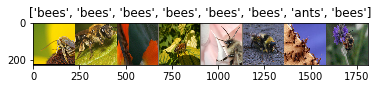

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



Basic Training Function , the scheduler is lr=0.001, decays by 0.1 every 7 epochs

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses=[]
    val_losses=[]
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                #print(inputs.size())
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            print('{} Rajat Best_Acc: {:.4f} Epoch_Acc: {:.4f}'.format(
                phase, best_acc, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            #collect losses
            if phase=='train':
                train_losses.append(epoch_loss)
            if phase=='val':
                val_losses.append(epoch_loss)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,train_losses,val_losses

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            print("modi",inputs.size())
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
import pandas as pd
def plot_losses(train_loss,val_loss):
    df = pd.DataFrame(list(zip([i for i in range(0,len(train_losses))],train_loss,val_loss)), 
               columns =['epoch', 'train_loss','val_loss']) 
    list_data=[df.train_loss,df.val_loss]
    plots=sns.lineplot(data=list_data)
    return plots

In [7]:
def dump_output(model,train_loss,val_loss,experiment_name):
    model_dump_path=experiment_name+'.pt'
    torch.save(model.state_dict(),model_dump_path)
    csv_dump_path=experiment_name+'.csv'
    df = pd.DataFrame(list(zip(train_loss,val_loss)), 
           columns =[ 'train_loss','val_loss'])
    df.to_csv(csv_dump_path)
    list_data=[df.train_loss,df.val_loss]
    plot_dump_path=experiment_name+'.png'
    plots=sns.lineplot(data=list_data)
    fig=plots.get_figure()
    fig.savefig(plot_dump_path)

E1. Train whole model, LR scheduler, 100 epochs, resnet18 
----------------------------------------------------------------------------
Resnet18, train the whole model

Best val Acc: 0.960784


In [9]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [10]:
model_ft,train_losses,val_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=500)

Epoch 0/499
----------
train Loss: 0.5623 Acc: 0.6967
train Rajat Best_Acc: 0.0000 Epoch_Acc: 0.6967
val Loss: 0.2138 Acc: 0.9281
val Rajat Best_Acc: 0.0000 Epoch_Acc: 0.9281

Epoch 1/499
----------
train Loss: 0.3042 Acc: 0.8566
train Rajat Best_Acc: 0.9281 Epoch_Acc: 0.8566
val Loss: 0.2095 Acc: 0.9346
val Rajat Best_Acc: 0.9281 Epoch_Acc: 0.9346

Epoch 2/499
----------
train Loss: 0.2776 Acc: 0.8811
train Rajat Best_Acc: 0.9346 Epoch_Acc: 0.8811
val Loss: 0.1820 Acc: 0.9346
val Rajat Best_Acc: 0.9346 Epoch_Acc: 0.9346

Epoch 3/499
----------
train Loss: 0.1933 Acc: 0.9262
train Rajat Best_Acc: 0.9346 Epoch_Acc: 0.9262
val Loss: 0.1743 Acc: 0.9477
val Rajat Best_Acc: 0.9346 Epoch_Acc: 0.9477

Epoch 4/499
----------
train Loss: 0.2324 Acc: 0.9057
train Rajat Best_Acc: 0.9477 Epoch_Acc: 0.9057
val Loss: 0.1126 Acc: 0.9477
val Rajat Best_Acc: 0.9477 Epoch_Acc: 0.9477

Epoch 5/499
----------
train Loss: 0.2953 Acc: 0.8811
train Rajat Best_Acc: 0.9477 Epoch_Acc: 0.8811
val Loss: 0.1704 Ac

val Loss: 0.1759 Acc: 0.9281
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9281

Epoch 47/499
----------
train Loss: 0.1689 Acc: 0.9344
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9344
val Loss: 0.1763 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 48/499
----------
train Loss: 0.1509 Acc: 0.9385
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9385
val Loss: 0.1709 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 49/499
----------
train Loss: 0.1585 Acc: 0.9262
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9262
val Loss: 0.1744 Acc: 0.9281
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9281

Epoch 50/499
----------
train Loss: 0.1189 Acc: 0.9508
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9508
val Loss: 0.1697 Acc: 0.9281
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9281

Epoch 51/499
----------
train Loss: 0.1346 Acc: 0.9508
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9508
val Loss: 0.1629 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 52/499
----------
train Loss: 0.12

train Loss: 0.1616 Acc: 0.9221
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9221
val Loss: 0.1718 Acc: 0.9216
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9216

Epoch 94/499
----------
train Loss: 0.1237 Acc: 0.9508
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9508
val Loss: 0.1728 Acc: 0.9281
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9281

Epoch 95/499
----------
train Loss: 0.1573 Acc: 0.9385
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9385
val Loss: 0.1850 Acc: 0.9150
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9150

Epoch 96/499
----------
train Loss: 0.1362 Acc: 0.9508
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9508
val Loss: 0.1993 Acc: 0.9216
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9216

Epoch 97/499
----------
train Loss: 0.1051 Acc: 0.9672
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9672
val Loss: 0.1619 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 98/499
----------
train Loss: 0.1558 Acc: 0.9508
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9508
val Loss: 0.1773 Acc: 0.9216
val Raja

val Loss: 0.1963 Acc: 0.9150
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9150

Epoch 140/499
----------
train Loss: 0.1678 Acc: 0.9344
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9344
val Loss: 0.1885 Acc: 0.9150
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9150

Epoch 141/499
----------
train Loss: 0.1375 Acc: 0.9385
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9385
val Loss: 0.1654 Acc: 0.9281
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9281

Epoch 142/499
----------
train Loss: 0.1067 Acc: 0.9590
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9590
val Loss: 0.1649 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 143/499
----------
train Loss: 0.0940 Acc: 0.9590
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9590
val Loss: 0.1619 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 144/499
----------
train Loss: 0.1470 Acc: 0.9426
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9426
val Loss: 0.1749 Acc: 0.9281
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9281

Epoch 145/499
----------
train Loss

train Loss: 0.1488 Acc: 0.9426
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9426
val Loss: 0.1818 Acc: 0.9281
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9281

Epoch 187/499
----------
train Loss: 0.1285 Acc: 0.9549
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9549
val Loss: 0.1673 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 188/499
----------
train Loss: 0.1328 Acc: 0.9590
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9590
val Loss: 0.1772 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 189/499
----------
train Loss: 0.1440 Acc: 0.9426
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9426
val Loss: 0.1619 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 190/499
----------
train Loss: 0.0954 Acc: 0.9590
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9590
val Loss: 0.1877 Acc: 0.9216
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9216

Epoch 191/499
----------
train Loss: 0.2035 Acc: 0.9098
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9098
val Loss: 0.1667 Acc: 0.9281
val

val Loss: 0.1705 Acc: 0.9281
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9281

Epoch 233/499
----------
train Loss: 0.1467 Acc: 0.9631
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9631
val Loss: 0.1799 Acc: 0.9281
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9281

Epoch 234/499
----------
train Loss: 0.1773 Acc: 0.9303
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9303
val Loss: 0.1723 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 235/499
----------
train Loss: 0.1826 Acc: 0.9344
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9344
val Loss: 0.2003 Acc: 0.9150
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9150

Epoch 236/499
----------
train Loss: 0.1079 Acc: 0.9590
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9590
val Loss: 0.1777 Acc: 0.9216
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9216

Epoch 237/499
----------
train Loss: 0.1480 Acc: 0.9262
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9262
val Loss: 0.1767 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 238/499
----------
train Loss

train Loss: 0.1881 Acc: 0.9221
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9221
val Loss: 0.1659 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 280/499
----------
train Loss: 0.1297 Acc: 0.9426
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9426
val Loss: 0.1754 Acc: 0.9281
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9281

Epoch 281/499
----------
train Loss: 0.1685 Acc: 0.9303
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9303
val Loss: 0.1619 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 282/499
----------
train Loss: 0.1417 Acc: 0.9344
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9344
val Loss: 0.1616 Acc: 0.9477
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9477

Epoch 283/499
----------
train Loss: 0.1521 Acc: 0.9426
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9426
val Loss: 0.1630 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 284/499
----------
train Loss: 0.1252 Acc: 0.9508
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9508
val Loss: 0.1698 Acc: 0.9346
val

val Loss: 0.1692 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 326/499
----------
train Loss: 0.1741 Acc: 0.9262
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9262
val Loss: 0.1651 Acc: 0.9281
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9281

Epoch 327/499
----------
train Loss: 0.1884 Acc: 0.9221
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9221
val Loss: 0.1836 Acc: 0.9216
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9216

Epoch 328/499
----------
train Loss: 0.1463 Acc: 0.9467
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9467
val Loss: 0.1655 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 329/499
----------
train Loss: 0.1254 Acc: 0.9508
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9508
val Loss: 0.1651 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 330/499
----------
train Loss: 0.1132 Acc: 0.9549
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9549
val Loss: 0.1700 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 331/499
----------
train Loss

train Loss: 0.1999 Acc: 0.8934
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.8934
val Loss: 0.1655 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 373/499
----------
train Loss: 0.1871 Acc: 0.9221
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9221
val Loss: 0.1738 Acc: 0.9281
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9281

Epoch 374/499
----------
train Loss: 0.2363 Acc: 0.9016
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9016
val Loss: 0.1602 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 375/499
----------
train Loss: 0.1804 Acc: 0.9303
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9303
val Loss: 0.1727 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 376/499
----------
train Loss: 0.1658 Acc: 0.9221
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9221
val Loss: 0.1629 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 377/499
----------
train Loss: 0.1086 Acc: 0.9549
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9549
val Loss: 0.1798 Acc: 0.9216
val

val Loss: 0.1715 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 419/499
----------
train Loss: 0.1208 Acc: 0.9426
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9426
val Loss: 0.1763 Acc: 0.9281
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9281

Epoch 420/499
----------
train Loss: 0.0997 Acc: 0.9631
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9631
val Loss: 0.1724 Acc: 0.9281
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9281

Epoch 421/499
----------
train Loss: 0.1640 Acc: 0.9262
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9262
val Loss: 0.1918 Acc: 0.9150
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9150

Epoch 422/499
----------
train Loss: 0.1212 Acc: 0.9549
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9549
val Loss: 0.1779 Acc: 0.9216
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9216

Epoch 423/499
----------
train Loss: 0.1499 Acc: 0.9508
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9508
val Loss: 0.1809 Acc: 0.9150
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9150

Epoch 424/499
----------
train Loss

train Loss: 0.1268 Acc: 0.9467
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9467
val Loss: 0.1733 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 466/499
----------
train Loss: 0.1926 Acc: 0.9385
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9385
val Loss: 0.1685 Acc: 0.9281
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9281

Epoch 467/499
----------
train Loss: 0.1940 Acc: 0.9467
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9467
val Loss: 0.1692 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 468/499
----------
train Loss: 0.1486 Acc: 0.9344
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9344
val Loss: 0.1743 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 469/499
----------
train Loss: 0.1879 Acc: 0.9180
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9180
val Loss: 0.1602 Acc: 0.9281
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9281

Epoch 470/499
----------
train Loss: 0.1057 Acc: 0.9549
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9549
val Loss: 0.1959 Acc: 0.9281
val

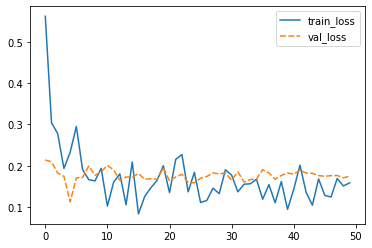

In [11]:
dump_output(model_ft,train_losses[0:50],val_losses[0:50],'resnet18_lrscheduler_wholenetwork')

E2)Train lastlayer, LR scheduler, 100 epochs, resnet18 
----------------------------------

Resnet18, train the last layer only

Best val Acc: 0.954248


In [12]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [13]:
model_conv.fc

Linear(in_features=512, out_features=2, bias=True)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [14]:
model_ft,train_losses,val_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=500)

Epoch 0/499
----------
train Loss: 0.1569 Acc: 0.9385
train Rajat Best_Acc: 0.0000 Epoch_Acc: 0.9385


/home/bashturtle/anaconda3/envs/gpuenv/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


val Loss: 0.1721 Acc: 0.9346
val Rajat Best_Acc: 0.0000 Epoch_Acc: 0.9346

Epoch 1/499
----------
train Loss: 0.2692 Acc: 0.8852
train Rajat Best_Acc: 0.9346 Epoch_Acc: 0.8852
val Loss: 0.1631 Acc: 0.9477
val Rajat Best_Acc: 0.9346 Epoch_Acc: 0.9477

Epoch 2/499
----------
train Loss: 0.1435 Acc: 0.9467
train Rajat Best_Acc: 0.9477 Epoch_Acc: 0.9467
val Loss: 0.1761 Acc: 0.9281
val Rajat Best_Acc: 0.9477 Epoch_Acc: 0.9281

Epoch 3/499
----------
train Loss: 0.0726 Acc: 0.9836
train Rajat Best_Acc: 0.9477 Epoch_Acc: 0.9836
val Loss: 0.1650 Acc: 0.9346
val Rajat Best_Acc: 0.9477 Epoch_Acc: 0.9346

Epoch 4/499
----------
train Loss: 0.1864 Acc: 0.9262
train Rajat Best_Acc: 0.9477 Epoch_Acc: 0.9262
val Loss: 0.1709 Acc: 0.9281
val Rajat Best_Acc: 0.9477 Epoch_Acc: 0.9281

Epoch 5/499
----------
train Loss: 0.1536 Acc: 0.9303
train Rajat Best_Acc: 0.9477 Epoch_Acc: 0.9303
val Loss: 0.1647 Acc: 0.9346
val Rajat Best_Acc: 0.9477 Epoch_Acc: 0.9346

Epoch 6/499
----------
train Loss: 0.1789 Acc

train Loss: 0.1534 Acc: 0.9344
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9344
val Loss: 0.1741 Acc: 0.9281
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9281

Epoch 48/499
----------
train Loss: 0.1245 Acc: 0.9467
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9467
val Loss: 0.1826 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 49/499
----------
train Loss: 0.1340 Acc: 0.9385
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9385
val Loss: 0.1687 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 50/499
----------
train Loss: 0.1434 Acc: 0.9303
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9303
val Loss: 0.1676 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 51/499
----------
train Loss: 0.1566 Acc: 0.9467
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9467
val Loss: 0.1709 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 52/499
----------
train Loss: 0.1340 Acc: 0.9385
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9385
val Loss: 0.1681 Acc: 0.9346
val Raja

val Loss: 0.1669 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 94/499
----------
train Loss: 0.0808 Acc: 0.9713
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9713
val Loss: 0.1655 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 95/499
----------
train Loss: 0.0895 Acc: 0.9713
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9713
val Loss: 0.1775 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 96/499
----------
train Loss: 0.1681 Acc: 0.9385
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9385
val Loss: 0.1649 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 97/499
----------
train Loss: 0.1899 Acc: 0.9344
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9344
val Loss: 0.1661 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 98/499
----------
train Loss: 0.1099 Acc: 0.9590
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9590
val Loss: 0.1812 Acc: 0.9216
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9216

Epoch 99/499
----------
train Loss: 0.15

train Loss: 0.1191 Acc: 0.9426
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9426
val Loss: 0.1674 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 141/499
----------
train Loss: 0.1212 Acc: 0.9467
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9467
val Loss: 0.1796 Acc: 0.9281
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9281

Epoch 142/499
----------
train Loss: 0.1325 Acc: 0.9549
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9549
val Loss: 0.1697 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 143/499
----------
train Loss: 0.1073 Acc: 0.9631
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9631
val Loss: 0.1886 Acc: 0.9281
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9281

Epoch 144/499
----------
train Loss: 0.1389 Acc: 0.9385
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9385
val Loss: 0.1723 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 145/499
----------
train Loss: 0.1141 Acc: 0.9590
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9590
val Loss: 0.1667 Acc: 0.9346
val

val Loss: 0.1880 Acc: 0.9216
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9216

Epoch 187/499
----------
train Loss: 0.1832 Acc: 0.9262
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9262
val Loss: 0.1939 Acc: 0.9150
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9150

Epoch 188/499
----------
train Loss: 0.1416 Acc: 0.9426
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9426
val Loss: 0.1633 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 189/499
----------
train Loss: 0.1068 Acc: 0.9590
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9590
val Loss: 0.1642 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 190/499
----------
train Loss: 0.1840 Acc: 0.9057
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9057
val Loss: 0.1742 Acc: 0.9216
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9216

Epoch 191/499
----------
train Loss: 0.1074 Acc: 0.9713
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9713
val Loss: 0.1804 Acc: 0.9281
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9281

Epoch 192/499
----------
train Loss

train Loss: 0.1423 Acc: 0.9508
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9508
val Loss: 0.1829 Acc: 0.9281
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9281

Epoch 234/499
----------
train Loss: 0.1571 Acc: 0.9385
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9385
val Loss: 0.1713 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 235/499
----------
train Loss: 0.1168 Acc: 0.9631
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9631
val Loss: 0.1633 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 236/499
----------
train Loss: 0.1207 Acc: 0.9508
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9508
val Loss: 0.1679 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 237/499
----------
train Loss: 0.1758 Acc: 0.9262
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9262
val Loss: 0.1738 Acc: 0.9216
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9216

Epoch 238/499
----------
train Loss: 0.0942 Acc: 0.9590
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9590
val Loss: 0.1699 Acc: 0.9412
val

val Loss: 0.1732 Acc: 0.9281
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9281

Epoch 280/499
----------
train Loss: 0.1673 Acc: 0.9303
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9303
val Loss: 0.1783 Acc: 0.9216
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9216

Epoch 281/499
----------
train Loss: 0.1251 Acc: 0.9385
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9385
val Loss: 0.1816 Acc: 0.9216
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9216

Epoch 282/499
----------
train Loss: 0.1035 Acc: 0.9631
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9631
val Loss: 0.1737 Acc: 0.9281
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9281

Epoch 283/499
----------
train Loss: 0.0994 Acc: 0.9631
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9631
val Loss: 0.1681 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 284/499
----------
train Loss: 0.1708 Acc: 0.9426
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9426
val Loss: 0.1772 Acc: 0.9281
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9281

Epoch 285/499
----------
train Loss

train Loss: 0.1468 Acc: 0.9467
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9467
val Loss: 0.1752 Acc: 0.9281
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9281

Epoch 327/499
----------
train Loss: 0.1941 Acc: 0.9139
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9139
val Loss: 0.1637 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 328/499
----------
train Loss: 0.1472 Acc: 0.9467
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9467
val Loss: 0.1884 Acc: 0.9281
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9281

Epoch 329/499
----------
train Loss: 0.1668 Acc: 0.9221
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9221
val Loss: 0.1724 Acc: 0.9281
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9281

Epoch 330/499
----------
train Loss: 0.0995 Acc: 0.9672
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9672
val Loss: 0.1667 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 331/499
----------
train Loss: 0.1506 Acc: 0.9344
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9344
val Loss: 0.1793 Acc: 0.9216
val

val Loss: 0.1773 Acc: 0.9216
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9216

Epoch 373/499
----------
train Loss: 0.1731 Acc: 0.9262
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9262
val Loss: 0.1667 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 374/499
----------
train Loss: 0.0978 Acc: 0.9754
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9754
val Loss: 0.1614 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 375/499
----------
train Loss: 0.1699 Acc: 0.9385
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9385
val Loss: 0.1763 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 376/499
----------
train Loss: 0.1605 Acc: 0.9139
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9139
val Loss: 0.1658 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 377/499
----------
train Loss: 0.2750 Acc: 0.8852
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.8852
val Loss: 0.1778 Acc: 0.9216
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9216

Epoch 378/499
----------
train Loss

train Loss: 0.1665 Acc: 0.9303
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9303
val Loss: 0.1740 Acc: 0.9281
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9281

Epoch 420/499
----------
train Loss: 0.1196 Acc: 0.9508
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9508
val Loss: 0.1695 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 421/499
----------
train Loss: 0.1098 Acc: 0.9631
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9631
val Loss: 0.1773 Acc: 0.9281
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9281

Epoch 422/499
----------
train Loss: 0.1625 Acc: 0.9262
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9262
val Loss: 0.1704 Acc: 0.9281
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9281

Epoch 423/499
----------
train Loss: 0.2224 Acc: 0.8975
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.8975
val Loss: 0.1663 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 424/499
----------
train Loss: 0.1425 Acc: 0.9590
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9590
val Loss: 0.1647 Acc: 0.9477
val

val Loss: 0.1820 Acc: 0.9216
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9216

Epoch 466/499
----------
train Loss: 0.1177 Acc: 0.9590
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9590
val Loss: 0.1749 Acc: 0.9281
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9281

Epoch 467/499
----------
train Loss: 0.1319 Acc: 0.9385
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9385
val Loss: 0.1663 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 468/499
----------
train Loss: 0.0903 Acc: 0.9672
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9672
val Loss: 0.1768 Acc: 0.9281
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9281

Epoch 469/499
----------
train Loss: 0.0897 Acc: 0.9672
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9672
val Loss: 0.1796 Acc: 0.9281
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9281

Epoch 470/499
----------
train Loss: 0.1384 Acc: 0.9467
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9467
val Loss: 0.1660 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 471/499
----------
train Loss

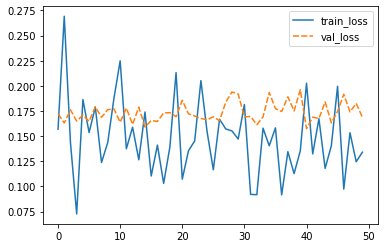

In [15]:
dump_output(model_ft,train_losses[0:50],val_losses[0:50],'resnet18_lrscheduler_lastlayer')

E3)Train wholenetwork, LR scheduler, 1000 epochs, resnet34 
----------------------------------

Resnet34, train the whole network




In [16]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft,train_losses,val_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=500)

Epoch 0/499
----------
train Loss: 0.5683 Acc: 0.6967
train Rajat Best_Acc: 0.0000 Epoch_Acc: 0.6967
val Loss: 0.2942 Acc: 0.8693
val Rajat Best_Acc: 0.0000 Epoch_Acc: 0.8693

Epoch 1/499
----------
train Loss: 0.2670 Acc: 0.8975
train Rajat Best_Acc: 0.8693 Epoch_Acc: 0.8975
val Loss: 0.1716 Acc: 0.9346
val Rajat Best_Acc: 0.8693 Epoch_Acc: 0.9346

Epoch 2/499
----------
train Loss: 0.2942 Acc: 0.8852
train Rajat Best_Acc: 0.9346 Epoch_Acc: 0.8852
val Loss: 0.1524 Acc: 0.9608
val Rajat Best_Acc: 0.9346 Epoch_Acc: 0.9608

Epoch 3/499
----------
train Loss: 0.2833 Acc: 0.8852
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.8852
val Loss: 0.1684 Acc: 0.9216
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9216

Epoch 4/499
----------
train Loss: 0.1692 Acc: 0.9262
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9262
val Loss: 0.1636 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 5/499
----------
train Loss: 0.1408 Acc: 0.9344
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9344
val Loss: 0.1614 Ac

val Loss: 0.1687 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 47/499
----------
train Loss: 0.0983 Acc: 0.9549
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9549
val Loss: 0.1640 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 48/499
----------
train Loss: 0.1054 Acc: 0.9631
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9631
val Loss: 0.1651 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 49/499
----------
train Loss: 0.1990 Acc: 0.9303
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9303
val Loss: 0.1721 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 50/499
----------
train Loss: 0.1070 Acc: 0.9631
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9631
val Loss: 0.1832 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 51/499
----------
train Loss: 0.1226 Acc: 0.9385
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9385
val Loss: 0.1577 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 52/499
----------
train Loss: 0.17

train Loss: 0.0793 Acc: 0.9754
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9754
val Loss: 0.1646 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 94/499
----------
train Loss: 0.1040 Acc: 0.9754
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9754
val Loss: 0.1613 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 95/499
----------
train Loss: 0.1952 Acc: 0.9180
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9180
val Loss: 0.1790 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 96/499
----------
train Loss: 0.0602 Acc: 0.9795
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9795
val Loss: 0.1650 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 97/499
----------
train Loss: 0.0841 Acc: 0.9795
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9795
val Loss: 0.1668 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 98/499
----------
train Loss: 0.1041 Acc: 0.9549
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9549
val Loss: 0.1640 Acc: 0.9542
val Raja

val Loss: 0.1640 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 140/499
----------
train Loss: 0.1500 Acc: 0.9426
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9426
val Loss: 0.1559 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 141/499
----------
train Loss: 0.1339 Acc: 0.9508
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9508
val Loss: 0.1650 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 142/499
----------
train Loss: 0.1191 Acc: 0.9508
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9508
val Loss: 0.1791 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 143/499
----------
train Loss: 0.0946 Acc: 0.9590
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9590
val Loss: 0.1809 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 144/499
----------
train Loss: 0.1261 Acc: 0.9549
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9549
val Loss: 0.1726 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 145/499
----------
train Loss

train Loss: 0.2152 Acc: 0.9180
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9180
val Loss: 0.1702 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 187/499
----------
train Loss: 0.0878 Acc: 0.9549
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9549
val Loss: 0.1924 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 188/499
----------
train Loss: 0.1208 Acc: 0.9508
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9508
val Loss: 0.1632 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 189/499
----------
train Loss: 0.1219 Acc: 0.9590
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9590
val Loss: 0.1674 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 190/499
----------
train Loss: 0.0591 Acc: 0.9836
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9836
val Loss: 0.1651 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 191/499
----------
train Loss: 0.1096 Acc: 0.9549
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9549
val Loss: 0.1662 Acc: 0.9477
val

val Loss: 0.1667 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 233/499
----------
train Loss: 0.1051 Acc: 0.9672
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9672
val Loss: 0.1701 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 234/499
----------
train Loss: 0.0969 Acc: 0.9672
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9672
val Loss: 0.1573 Acc: 0.9608
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9608

Epoch 235/499
----------
train Loss: 0.1660 Acc: 0.9262
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9262
val Loss: 0.1706 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 236/499
----------
train Loss: 0.1377 Acc: 0.9508
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9508
val Loss: 0.1614 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 237/499
----------
train Loss: 0.1090 Acc: 0.9508
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9508
val Loss: 0.1622 Acc: 0.9608
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9608

Epoch 238/499
----------
train Loss

train Loss: 0.2106 Acc: 0.9303
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9303
val Loss: 0.1721 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 280/499
----------
train Loss: 0.1400 Acc: 0.9508
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9508
val Loss: 0.1600 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 281/499
----------
train Loss: 0.1685 Acc: 0.9139
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9139
val Loss: 0.1618 Acc: 0.9608
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9608

Epoch 282/499
----------
train Loss: 0.0926 Acc: 0.9590
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9590
val Loss: 0.1692 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 283/499
----------
train Loss: 0.1637 Acc: 0.9426
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9426
val Loss: 0.1569 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 284/499
----------
train Loss: 0.0870 Acc: 0.9754
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9754
val Loss: 0.1587 Acc: 0.9542
val

val Loss: 0.1660 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 326/499
----------
train Loss: 0.1505 Acc: 0.9385
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9385
val Loss: 0.1765 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 327/499
----------
train Loss: 0.0955 Acc: 0.9549
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9549
val Loss: 0.1734 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 328/499
----------
train Loss: 0.1307 Acc: 0.9426
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9426
val Loss: 0.1705 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 329/499
----------
train Loss: 0.1526 Acc: 0.9303
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9303
val Loss: 0.1646 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 330/499
----------
train Loss: 0.1771 Acc: 0.9262
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9262
val Loss: 0.1635 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 331/499
----------
train Loss

train Loss: 0.1621 Acc: 0.9221
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9221
val Loss: 0.1653 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 373/499
----------
train Loss: 0.1051 Acc: 0.9631
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9631
val Loss: 0.1792 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 374/499
----------
train Loss: 0.1312 Acc: 0.9426
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9426
val Loss: 0.1725 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 375/499
----------
train Loss: 0.1545 Acc: 0.9508
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9508
val Loss: 0.1592 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 376/499
----------
train Loss: 0.1082 Acc: 0.9590
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9590
val Loss: 0.1652 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 377/499
----------
train Loss: 0.1003 Acc: 0.9672
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9672
val Loss: 0.1646 Acc: 0.9477
val

val Loss: 0.1633 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 419/499
----------
train Loss: 0.1918 Acc: 0.9180
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9180
val Loss: 0.1658 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 420/499
----------
train Loss: 0.1206 Acc: 0.9467
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9467
val Loss: 0.1511 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 421/499
----------
train Loss: 0.1510 Acc: 0.9344
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9344
val Loss: 0.1644 Acc: 0.9281
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9281

Epoch 422/499
----------
train Loss: 0.1219 Acc: 0.9590
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9590
val Loss: 0.1683 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 423/499
----------
train Loss: 0.0919 Acc: 0.9672
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9672
val Loss: 0.1747 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 424/499
----------
train Loss

train Loss: 0.1368 Acc: 0.9426
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9426
val Loss: 0.1648 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 466/499
----------
train Loss: 0.1578 Acc: 0.9262
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9262
val Loss: 0.1637 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 467/499
----------
train Loss: 0.0974 Acc: 0.9672
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9672
val Loss: 0.1653 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 468/499
----------
train Loss: 0.1074 Acc: 0.9590
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9590
val Loss: 0.1622 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 469/499
----------
train Loss: 0.1045 Acc: 0.9549
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9549
val Loss: 0.1602 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 470/499
----------
train Loss: 0.1276 Acc: 0.9426
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9426
val Loss: 0.1656 Acc: 0.9542
val

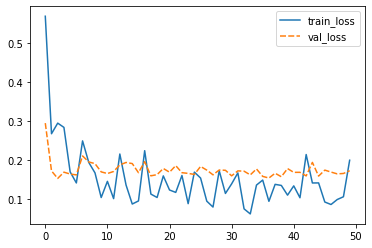

In [17]:
dump_output(model_ft,train_losses[0:50],val_losses[0:50],'resnet34_lrscheduler_wholenetwork')

E4)Train lastlayer, LR scheduler, 100 epochs, resnet34 
----------------------------------

Resnet18, train the last layer only

Best val Acc: 0.954248


In [18]:
model_conv = torchvision.models.resnet34(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_ft,train_losses,val_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=500)

Epoch 0/499
----------
train Loss: 0.2349 Acc: 0.9016
train Rajat Best_Acc: 0.0000 Epoch_Acc: 0.9016
val Loss: 0.1560 Acc: 0.9608
val Rajat Best_Acc: 0.0000 Epoch_Acc: 0.9608

Epoch 1/499
----------
train Loss: 0.1552 Acc: 0.9426
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9426
val Loss: 0.1531 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 2/499
----------
train Loss: 0.2006 Acc: 0.9262
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9262
val Loss: 0.1479 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 3/499
----------
train Loss: 0.1644 Acc: 0.9344
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9344
val Loss: 0.1542 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 4/499
----------
train Loss: 0.2115 Acc: 0.9098
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9098
val Loss: 0.1487 Acc: 0.9608
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9608

Epoch 5/499
----------
train Loss: 0.2417 Acc: 0.8975
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.8975
val Loss: 0.1503 Ac

val Loss: 0.1463 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 47/499
----------
train Loss: 0.1929 Acc: 0.9098
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9098
val Loss: 0.1545 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 48/499
----------
train Loss: 0.2255 Acc: 0.9180
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9180
val Loss: 0.1489 Acc: 0.9477
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9477

Epoch 49/499
----------
train Loss: 0.1693 Acc: 0.9426
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9426
val Loss: 0.1547 Acc: 0.9542
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9542

Epoch 50/499
----------
train Loss: 0.1662 Acc: 0.9344
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9344
val Loss: 0.1558 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 51/499
----------
train Loss: 0.1670 Acc: 0.9467
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9467
val Loss: 0.1535 Acc: 0.9542
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9542

Epoch 52/499
----------
train Loss: 0.20

train Loss: 0.1784 Acc: 0.9221
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9221
val Loss: 0.1500 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 94/499
----------
train Loss: 0.1787 Acc: 0.9385
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9385
val Loss: 0.1493 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 95/499
----------
train Loss: 0.1575 Acc: 0.9303
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9303
val Loss: 0.1486 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 96/499
----------
train Loss: 0.1693 Acc: 0.9508
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9508
val Loss: 0.1534 Acc: 0.9542
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9542

Epoch 97/499
----------
train Loss: 0.1605 Acc: 0.9672
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9672
val Loss: 0.1423 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 98/499
----------
train Loss: 0.1434 Acc: 0.9590
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9590
val Loss: 0.1592 Acc: 0.9542
val Raja

val Loss: 0.1539 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 140/499
----------
train Loss: 0.1899 Acc: 0.9426
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9426
val Loss: 0.1450 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 141/499
----------
train Loss: 0.1482 Acc: 0.9385
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9385
val Loss: 0.1507 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 142/499
----------
train Loss: 0.1669 Acc: 0.9344
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9344
val Loss: 0.1681 Acc: 0.9412
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9412

Epoch 143/499
----------
train Loss: 0.1661 Acc: 0.9508
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9508
val Loss: 0.1468 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 144/499
----------
train Loss: 0.1771 Acc: 0.9139
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9139
val Loss: 0.1469 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 145/499
----------
train Loss

train Loss: 0.1848 Acc: 0.9426
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9426
val Loss: 0.1505 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 187/499
----------
train Loss: 0.1464 Acc: 0.9467
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9467
val Loss: 0.1522 Acc: 0.9542
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9542

Epoch 188/499
----------
train Loss: 0.2143 Acc: 0.9303
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9303
val Loss: 0.1470 Acc: 0.9673
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9673

Epoch 189/499
----------
train Loss: 0.1975 Acc: 0.9262
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9262
val Loss: 0.1619 Acc: 0.9542
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9542

Epoch 190/499
----------
train Loss: 0.2248 Acc: 0.9262
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9262
val Loss: 0.1475 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 191/499
----------
train Loss: 0.1489 Acc: 0.9344
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9344
val Loss: 0.1537 Acc: 0.9608
val

val Loss: 0.1511 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 233/499
----------
train Loss: 0.1982 Acc: 0.9139
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9139
val Loss: 0.1532 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 234/499
----------
train Loss: 0.1787 Acc: 0.9344
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9344
val Loss: 0.1436 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 235/499
----------
train Loss: 0.2092 Acc: 0.9262
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9262
val Loss: 0.1531 Acc: 0.9542
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9542

Epoch 236/499
----------
train Loss: 0.1773 Acc: 0.9426
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9426
val Loss: 0.1549 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 237/499
----------
train Loss: 0.1949 Acc: 0.9221
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9221
val Loss: 0.1558 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 238/499
----------
train Loss

train Loss: 0.2301 Acc: 0.9016
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9016
val Loss: 0.1411 Acc: 0.9542
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9542

Epoch 280/499
----------
train Loss: 0.1796 Acc: 0.9221
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9221
val Loss: 0.1437 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 281/499
----------
train Loss: 0.1712 Acc: 0.9344
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9344
val Loss: 0.1567 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 282/499
----------
train Loss: 0.1659 Acc: 0.9262
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9262
val Loss: 0.1545 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 283/499
----------
train Loss: 0.1786 Acc: 0.9221
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9221
val Loss: 0.1518 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 284/499
----------
train Loss: 0.1820 Acc: 0.9262
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9262
val Loss: 0.1590 Acc: 0.9477
val

val Loss: 0.1510 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 326/499
----------
train Loss: 0.2024 Acc: 0.9303
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9303
val Loss: 0.1561 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 327/499
----------
train Loss: 0.1596 Acc: 0.9344
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9344
val Loss: 0.1560 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 328/499
----------
train Loss: 0.1546 Acc: 0.9303
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9303
val Loss: 0.1474 Acc: 0.9542
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9542

Epoch 329/499
----------
train Loss: 0.2077 Acc: 0.9139
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9139
val Loss: 0.1561 Acc: 0.9542
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9542

Epoch 330/499
----------
train Loss: 0.1746 Acc: 0.9303
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9303
val Loss: 0.1490 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 331/499
----------
train Loss

train Loss: 0.1713 Acc: 0.9221
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9221
val Loss: 0.1442 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 373/499
----------
train Loss: 0.2111 Acc: 0.9139
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9139
val Loss: 0.1462 Acc: 0.9673
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9673

Epoch 374/499
----------
train Loss: 0.2155 Acc: 0.9180
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9180
val Loss: 0.1616 Acc: 0.9477
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9477

Epoch 375/499
----------
train Loss: 0.2090 Acc: 0.9139
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9139
val Loss: 0.1521 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 376/499
----------
train Loss: 0.1696 Acc: 0.9344
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9344
val Loss: 0.1490 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 377/499
----------
train Loss: 0.1773 Acc: 0.9139
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9139
val Loss: 0.1599 Acc: 0.9477
val

val Loss: 0.1472 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 419/499
----------
train Loss: 0.1838 Acc: 0.9303
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9303
val Loss: 0.1557 Acc: 0.9542
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9542

Epoch 420/499
----------
train Loss: 0.1728 Acc: 0.9139
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9139
val Loss: 0.1643 Acc: 0.9542
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9542

Epoch 421/499
----------
train Loss: 0.1693 Acc: 0.9303
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9303
val Loss: 0.1581 Acc: 0.9542
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9542

Epoch 422/499
----------
train Loss: 0.1915 Acc: 0.9139
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9139
val Loss: 0.1454 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 423/499
----------
train Loss: 0.1533 Acc: 0.9262
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9262
val Loss: 0.1504 Acc: 0.9542
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9542

Epoch 424/499
----------
train Loss

train Loss: 0.2162 Acc: 0.9098
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9098
val Loss: 0.1495 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 466/499
----------
train Loss: 0.1599 Acc: 0.9467
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9467
val Loss: 0.1509 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 467/499
----------
train Loss: 0.1480 Acc: 0.9631
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9631
val Loss: 0.1551 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 468/499
----------
train Loss: 0.1942 Acc: 0.9303
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9303
val Loss: 0.1515 Acc: 0.9542
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9542

Epoch 469/499
----------
train Loss: 0.1717 Acc: 0.9262
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9262
val Loss: 0.1525 Acc: 0.9608
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9608

Epoch 470/499
----------
train Loss: 0.2204 Acc: 0.9139
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9139
val Loss: 0.1474 Acc: 0.9608
val

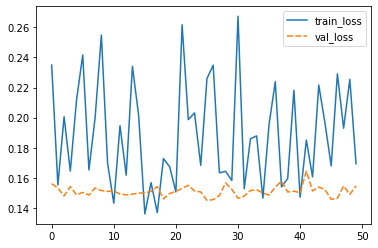

In [19]:
dump_output(model_ft,train_losses[0:50],val_losses[0:50],'resnet34_lrscheduler_lastlayer')

E5)Train wholenetwork, LR scheduler, 500 epochs, resnet50 
----------------------------------

Resnet50, train the whole network




In [21]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft,train_losses,val_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=500)

Epoch 0/499
----------
train Loss: 0.4558 Acc: 0.8238
train Rajat Best_Acc: 0.0000 Epoch_Acc: 0.8238
val Loss: 0.2793 Acc: 0.9020
val Rajat Best_Acc: 0.0000 Epoch_Acc: 0.9020

Epoch 1/499
----------
train Loss: 0.2579 Acc: 0.9016
train Rajat Best_Acc: 0.9020 Epoch_Acc: 0.9016
val Loss: 0.1590 Acc: 0.9412
val Rajat Best_Acc: 0.9020 Epoch_Acc: 0.9412

Epoch 2/499
----------
train Loss: 0.1546 Acc: 0.9385
train Rajat Best_Acc: 0.9412 Epoch_Acc: 0.9385
val Loss: 0.1199 Acc: 0.9412
val Rajat Best_Acc: 0.9412 Epoch_Acc: 0.9412

Epoch 3/499
----------
train Loss: 0.1988 Acc: 0.9098
train Rajat Best_Acc: 0.9412 Epoch_Acc: 0.9098
val Loss: 0.1521 Acc: 0.9477
val Rajat Best_Acc: 0.9412 Epoch_Acc: 0.9477

Epoch 4/499
----------
train Loss: 0.2036 Acc: 0.9303
train Rajat Best_Acc: 0.9477 Epoch_Acc: 0.9303
val Loss: 0.1693 Acc: 0.9346
val Rajat Best_Acc: 0.9477 Epoch_Acc: 0.9346

Epoch 5/499
----------
train Loss: 0.1314 Acc: 0.9549
train Rajat Best_Acc: 0.9477 Epoch_Acc: 0.9549
val Loss: 0.1302 Ac

val Loss: 0.1377 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 47/499
----------
train Loss: 0.1133 Acc: 0.9508
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9508
val Loss: 0.1602 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 48/499
----------
train Loss: 0.1633 Acc: 0.9303
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9303
val Loss: 0.1569 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 49/499
----------
train Loss: 0.1222 Acc: 0.9672
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9672
val Loss: 0.1533 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 50/499
----------
train Loss: 0.1213 Acc: 0.9508
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9508
val Loss: 0.1996 Acc: 0.9216
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9216

Epoch 51/499
----------
train Loss: 0.0818 Acc: 0.9713
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9713
val Loss: 0.1716 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 52/499
----------
train Loss: 0.16

train Loss: 0.0685 Acc: 0.9713
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9713
val Loss: 0.1751 Acc: 0.9281
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9281

Epoch 94/499
----------
train Loss: 0.1868 Acc: 0.9221
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9221
val Loss: 0.1472 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 95/499
----------
train Loss: 0.1452 Acc: 0.9303
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9303
val Loss: 0.1444 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 96/499
----------
train Loss: 0.0561 Acc: 0.9836
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9836
val Loss: 0.1444 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 97/499
----------
train Loss: 0.1125 Acc: 0.9590
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9590
val Loss: 0.1762 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 98/499
----------
train Loss: 0.1607 Acc: 0.9262
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9262
val Loss: 0.1588 Acc: 0.9412
val Raja

val Loss: 0.1398 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 140/499
----------
train Loss: 0.1116 Acc: 0.9467
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9467
val Loss: 0.1530 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 141/499
----------
train Loss: 0.1062 Acc: 0.9590
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9590
val Loss: 0.1761 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 142/499
----------
train Loss: 0.0837 Acc: 0.9754
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9754
val Loss: 0.1535 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 143/499
----------
train Loss: 0.1473 Acc: 0.9508
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9508
val Loss: 0.1444 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 144/499
----------
train Loss: 0.1165 Acc: 0.9590
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9590
val Loss: 0.1383 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 145/499
----------
train Loss

train Loss: 0.1861 Acc: 0.9262
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9262
val Loss: 0.1395 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 187/499
----------
train Loss: 0.1180 Acc: 0.9508
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9508
val Loss: 0.1517 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 188/499
----------
train Loss: 0.1389 Acc: 0.9549
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9549
val Loss: 0.1476 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 189/499
----------
train Loss: 0.1267 Acc: 0.9549
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9549
val Loss: 0.1423 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 190/499
----------
train Loss: 0.1383 Acc: 0.9508
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9508
val Loss: 0.1509 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 191/499
----------
train Loss: 0.1119 Acc: 0.9631
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9631
val Loss: 0.1496 Acc: 0.9477
val

val Loss: 0.1469 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 233/499
----------
train Loss: 0.1117 Acc: 0.9590
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9590
val Loss: 0.1558 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 234/499
----------
train Loss: 0.1020 Acc: 0.9631
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9631
val Loss: 0.1624 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 235/499
----------
train Loss: 0.0789 Acc: 0.9754
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9754
val Loss: 0.1575 Acc: 0.9281
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9281

Epoch 236/499
----------
train Loss: 0.0966 Acc: 0.9508
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9508
val Loss: 0.1464 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 237/499
----------
train Loss: 0.1061 Acc: 0.9590
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9590
val Loss: 0.1460 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 238/499
----------
train Loss

train Loss: 0.1273 Acc: 0.9590
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9590
val Loss: 0.1401 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 280/499
----------
train Loss: 0.1394 Acc: 0.9631
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9631
val Loss: 0.1360 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 281/499
----------
train Loss: 0.1021 Acc: 0.9508
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9508
val Loss: 0.1470 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 282/499
----------
train Loss: 0.0499 Acc: 0.9959
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9959
val Loss: 0.1401 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 283/499
----------
train Loss: 0.1262 Acc: 0.9590
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9590
val Loss: 0.1639 Acc: 0.9281
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9281

Epoch 284/499
----------
train Loss: 0.1489 Acc: 0.9344
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9344
val Loss: 0.1755 Acc: 0.9281
val

val Loss: 0.1343 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 326/499
----------
train Loss: 0.1304 Acc: 0.9508
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9508
val Loss: 0.1626 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 327/499
----------
train Loss: 0.1385 Acc: 0.9549
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9549
val Loss: 0.1375 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 328/499
----------
train Loss: 0.1506 Acc: 0.9344
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9344
val Loss: 0.1372 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 329/499
----------
train Loss: 0.1147 Acc: 0.9590
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9590
val Loss: 0.1762 Acc: 0.9216
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9216

Epoch 330/499
----------
train Loss: 0.1307 Acc: 0.9262
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9262
val Loss: 0.1555 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 331/499
----------
train Loss

train Loss: 0.1129 Acc: 0.9590
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9590
val Loss: 0.1648 Acc: 0.9216
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9216

Epoch 373/499
----------
train Loss: 0.0962 Acc: 0.9631
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9631
val Loss: 0.1463 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 374/499
----------
train Loss: 0.1177 Acc: 0.9590
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9590
val Loss: 0.1508 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 375/499
----------
train Loss: 0.1818 Acc: 0.9139
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9139
val Loss: 0.1620 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 376/499
----------
train Loss: 0.0881 Acc: 0.9590
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9590
val Loss: 0.1505 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 377/499
----------
train Loss: 0.1176 Acc: 0.9508
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9508
val Loss: 0.1599 Acc: 0.9477
val

val Loss: 0.1550 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 419/499
----------
train Loss: 0.1610 Acc: 0.9303
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9303
val Loss: 0.1832 Acc: 0.9216
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9216

Epoch 420/499
----------
train Loss: 0.0930 Acc: 0.9713
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9713
val Loss: 0.1497 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 421/499
----------
train Loss: 0.0889 Acc: 0.9631
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9631
val Loss: 0.1538 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 422/499
----------
train Loss: 0.1058 Acc: 0.9672
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9672
val Loss: 0.1585 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 423/499
----------
train Loss: 0.1278 Acc: 0.9631
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9631
val Loss: 0.1722 Acc: 0.9216
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9216

Epoch 424/499
----------
train Loss

train Loss: 0.0834 Acc: 0.9754
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9754
val Loss: 0.1402 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 466/499
----------
train Loss: 0.3046 Acc: 0.8811
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.8811
val Loss: 0.1368 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 467/499
----------
train Loss: 0.1667 Acc: 0.9344
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9344
val Loss: 0.1665 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 468/499
----------
train Loss: 0.1105 Acc: 0.9672
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9672
val Loss: 0.1449 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 469/499
----------
train Loss: 0.1343 Acc: 0.9590
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9590
val Loss: 0.1520 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 470/499
----------
train Loss: 0.1357 Acc: 0.9426
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9426
val Loss: 0.1396 Acc: 0.9477
val

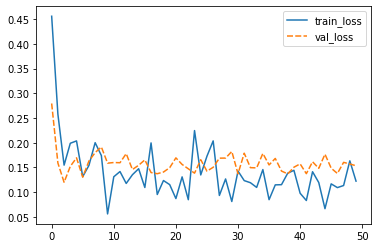

In [22]:
dump_output(model_ft,train_losses[0:50],val_losses[0:50],'resnet50_lrscheduler_wholenetwork')

E6)Train lastlayer, LR scheduler, 100 epochs, resnet50 
----------------------------------

Resnet18, train the last layer only

Best val Acc: 0.954248

In [23]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_ft,train_losses,val_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=500)

Epoch 0/499
----------
train Loss: 0.1173 Acc: 0.9631
train Rajat Best_Acc: 0.0000 Epoch_Acc: 0.9631
val Loss: 0.1566 Acc: 0.9281
val Rajat Best_Acc: 0.0000 Epoch_Acc: 0.9281

Epoch 1/499
----------
train Loss: 0.1781 Acc: 0.9180
train Rajat Best_Acc: 0.9281 Epoch_Acc: 0.9180
val Loss: 0.1469 Acc: 0.9412
val Rajat Best_Acc: 0.9281 Epoch_Acc: 0.9412

Epoch 2/499
----------
train Loss: 0.1529 Acc: 0.9426
train Rajat Best_Acc: 0.9412 Epoch_Acc: 0.9426
val Loss: 0.1459 Acc: 0.9346
val Rajat Best_Acc: 0.9412 Epoch_Acc: 0.9346

Epoch 3/499
----------
train Loss: 0.2530 Acc: 0.9098
train Rajat Best_Acc: 0.9412 Epoch_Acc: 0.9098
val Loss: 0.1616 Acc: 0.9346
val Rajat Best_Acc: 0.9412 Epoch_Acc: 0.9346

Epoch 4/499
----------
train Loss: 0.1955 Acc: 0.9262
train Rajat Best_Acc: 0.9412 Epoch_Acc: 0.9262
val Loss: 0.1414 Acc: 0.9412
val Rajat Best_Acc: 0.9412 Epoch_Acc: 0.9412

Epoch 5/499
----------
train Loss: 0.1764 Acc: 0.9426
train Rajat Best_Acc: 0.9412 Epoch_Acc: 0.9426
val Loss: 0.1343 Ac

val Loss: 0.1267 Acc: 0.9477
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9477

Epoch 47/499
----------
train Loss: 0.1431 Acc: 0.9303
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9303
val Loss: 0.1311 Acc: 0.9477
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9477

Epoch 48/499
----------
train Loss: 0.1528 Acc: 0.9426
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9426
val Loss: 0.1303 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 49/499
----------
train Loss: 0.1002 Acc: 0.9631
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9631
val Loss: 0.1327 Acc: 0.9477
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9477

Epoch 50/499
----------
train Loss: 0.2325 Acc: 0.9180
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9180
val Loss: 0.1386 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 51/499
----------
train Loss: 0.1058 Acc: 0.9631
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9631
val Loss: 0.1360 Acc: 0.9477
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9477

Epoch 52/499
----------
train Loss: 0.14

train Loss: 0.1926 Acc: 0.9303
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9303
val Loss: 0.1311 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 94/499
----------
train Loss: 0.0974 Acc: 0.9631
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9631
val Loss: 0.1357 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 95/499
----------
train Loss: 0.1195 Acc: 0.9508
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9508
val Loss: 0.1667 Acc: 0.9281
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9281

Epoch 96/499
----------
train Loss: 0.2215 Acc: 0.9139
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9139
val Loss: 0.1421 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 97/499
----------
train Loss: 0.1683 Acc: 0.9180
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9180
val Loss: 0.1324 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 98/499
----------
train Loss: 0.1370 Acc: 0.9385
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9385
val Loss: 0.1504 Acc: 0.9412
val Raja

val Loss: 0.1635 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 140/499
----------
train Loss: 0.2315 Acc: 0.9098
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9098
val Loss: 0.1345 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 141/499
----------
train Loss: 0.1747 Acc: 0.9180
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9180
val Loss: 0.1318 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 142/499
----------
train Loss: 0.1404 Acc: 0.9426
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9426
val Loss: 0.1383 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 143/499
----------
train Loss: 0.0964 Acc: 0.9672
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9672
val Loss: 0.1373 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 144/499
----------
train Loss: 0.1396 Acc: 0.9508
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9508
val Loss: 0.1475 Acc: 0.9281
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9281

Epoch 145/499
----------
train Loss

train Loss: 0.1621 Acc: 0.9344
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9344
val Loss: 0.1454 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 187/499
----------
train Loss: 0.1174 Acc: 0.9631
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9631
val Loss: 0.1405 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 188/499
----------
train Loss: 0.1560 Acc: 0.9303
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9303
val Loss: 0.1361 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 189/499
----------
train Loss: 0.1397 Acc: 0.9426
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9426
val Loss: 0.1377 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 190/499
----------
train Loss: 0.2129 Acc: 0.9262
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9262
val Loss: 0.1857 Acc: 0.9281
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9281

Epoch 191/499
----------
train Loss: 0.1547 Acc: 0.9303
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9303
val Loss: 0.1369 Acc: 0.9412
val

val Loss: 0.1298 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 233/499
----------
train Loss: 0.1321 Acc: 0.9426
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9426
val Loss: 0.1479 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 234/499
----------
train Loss: 0.1906 Acc: 0.9344
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9344
val Loss: 0.1686 Acc: 0.9281
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9281

Epoch 235/499
----------
train Loss: 0.1751 Acc: 0.9426
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9426
val Loss: 0.1416 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 236/499
----------
train Loss: 0.1051 Acc: 0.9549
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9549
val Loss: 0.1587 Acc: 0.9281
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9281

Epoch 237/499
----------
train Loss: 0.1990 Acc: 0.9262
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9262
val Loss: 0.1493 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 238/499
----------
train Loss

train Loss: 0.0918 Acc: 0.9590
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9590
val Loss: 0.1397 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 280/499
----------
train Loss: 0.1457 Acc: 0.9426
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9426
val Loss: 0.1434 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 281/499
----------
train Loss: 0.1094 Acc: 0.9631
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9631
val Loss: 0.1354 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 282/499
----------
train Loss: 0.0845 Acc: 0.9590
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9590
val Loss: 0.1412 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 283/499
----------
train Loss: 0.0869 Acc: 0.9754
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9754
val Loss: 0.1435 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 284/499
----------
train Loss: 0.1288 Acc: 0.9508
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9508
val Loss: 0.1388 Acc: 0.9281
val

val Loss: 0.1279 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 326/499
----------
train Loss: 0.1444 Acc: 0.9385
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9385
val Loss: 0.1524 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 327/499
----------
train Loss: 0.1813 Acc: 0.9303
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9303
val Loss: 0.1335 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 328/499
----------
train Loss: 0.1498 Acc: 0.9590
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9590
val Loss: 0.1438 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 329/499
----------
train Loss: 0.1017 Acc: 0.9549
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9549
val Loss: 0.1536 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 330/499
----------
train Loss: 0.1303 Acc: 0.9713
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9713
val Loss: 0.1417 Acc: 0.9281
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9281

Epoch 331/499
----------
train Loss

train Loss: 0.1478 Acc: 0.9549
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9549
val Loss: 0.1506 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 373/499
----------
train Loss: 0.1125 Acc: 0.9508
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9508
val Loss: 0.1471 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 374/499
----------
train Loss: 0.1986 Acc: 0.9262
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9262
val Loss: 0.1573 Acc: 0.9281
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9281

Epoch 375/499
----------
train Loss: 0.1356 Acc: 0.9426
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9426
val Loss: 0.1298 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 376/499
----------
train Loss: 0.1216 Acc: 0.9549
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9549
val Loss: 0.1432 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 377/499
----------
train Loss: 0.1422 Acc: 0.9549
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9549
val Loss: 0.1244 Acc: 0.9477
val

val Loss: 0.1480 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 419/499
----------
train Loss: 0.1565 Acc: 0.9426
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9426
val Loss: 0.1400 Acc: 0.9542
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9542

Epoch 420/499
----------
train Loss: 0.1495 Acc: 0.9385
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9385
val Loss: 0.1555 Acc: 0.9281
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9281

Epoch 421/499
----------
train Loss: 0.1512 Acc: 0.9467
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9467
val Loss: 0.1348 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 422/499
----------
train Loss: 0.1103 Acc: 0.9549
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9549
val Loss: 0.1577 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 423/499
----------
train Loss: 0.2026 Acc: 0.9221
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9221
val Loss: 0.1353 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 424/499
----------
train Loss

train Loss: 0.1684 Acc: 0.9139
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9139
val Loss: 0.1273 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 466/499
----------
train Loss: 0.1481 Acc: 0.9303
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9303
val Loss: 0.1329 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 467/499
----------
train Loss: 0.1192 Acc: 0.9549
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9549
val Loss: 0.1411 Acc: 0.9346
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9346

Epoch 468/499
----------
train Loss: 0.1817 Acc: 0.9385
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9385
val Loss: 0.1394 Acc: 0.9412
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9412

Epoch 469/499
----------
train Loss: 0.2276 Acc: 0.8893
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.8893
val Loss: 0.1294 Acc: 0.9477
val Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9477

Epoch 470/499
----------
train Loss: 0.1385 Acc: 0.9426
train Rajat Best_Acc: 0.9608 Epoch_Acc: 0.9426
val Loss: 0.1328 Acc: 0.9542
val

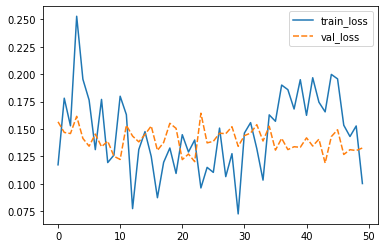

In [24]:
dump_output(model_ft,train_losses[0:50],val_losses[0:50],'resnet50_lrscheduler_lastlayer')

E7)Train WholeNetwork, LR scheduler, 100 epochs, resnet101
----------------------------------

Resnet101, train the whole network



Epoch 0/499
----------
train Loss: 0.5421 Acc: 0.6598
train Rajat Best_Acc: 0.0000 Epoch_Acc: 0.6598
val Loss: 0.1619 Acc: 0.9542
val Rajat Best_Acc: 0.0000 Epoch_Acc: 0.9542

Epoch 1/499
----------
train Loss: 0.3195 Acc: 0.8607
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.8607
val Loss: 0.1127 Acc: 0.9542
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9542

Epoch 2/499
----------
train Loss: 0.2412 Acc: 0.9057
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9057
val Loss: 0.3002 Acc: 0.8758
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.8758

Epoch 3/499
----------
train Loss: 0.2054 Acc: 0.9303
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9303
val Loss: 0.1306 Acc: 0.9542
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9542

Epoch 4/499
----------
train Loss: 0.1656 Acc: 0.9385
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9385
val Loss: 0.1881 Acc: 0.9085
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9085

Epoch 5/499
----------
train Loss: 0.1984 Acc: 0.9262
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9262
val Loss: 0.1370 Ac

val Loss: 0.1744 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 47/499
----------
train Loss: 0.1274 Acc: 0.9549
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9549
val Loss: 0.1494 Acc: 0.9477
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9477

Epoch 48/499
----------
train Loss: 0.0885 Acc: 0.9754
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9754
val Loss: 0.1478 Acc: 0.9477
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9477

Epoch 49/499
----------
train Loss: 0.0918 Acc: 0.9590
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9590
val Loss: 0.1486 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 50/499
----------
train Loss: 0.1512 Acc: 0.9467
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9467
val Loss: 0.1565 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 51/499
----------
train Loss: 0.1568 Acc: 0.9303
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9303
val Loss: 0.1524 Acc: 0.9477
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9477

Epoch 52/499
----------
train Loss: 0.11

train Loss: 0.1072 Acc: 0.9549
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9549
val Loss: 0.1448 Acc: 0.9477
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9477

Epoch 94/499
----------
train Loss: 0.1475 Acc: 0.9385
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9385
val Loss: 0.1391 Acc: 0.9542
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9542

Epoch 95/499
----------
train Loss: 0.0670 Acc: 0.9795
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9795
val Loss: 0.1379 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 96/499
----------
train Loss: 0.2089 Acc: 0.9180
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9180
val Loss: 0.1322 Acc: 0.9542
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9542

Epoch 97/499
----------
train Loss: 0.0897 Acc: 0.9713
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9713
val Loss: 0.1494 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 98/499
----------
train Loss: 0.1649 Acc: 0.9303
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9303
val Loss: 0.1630 Acc: 0.9346
val Raja

val Loss: 0.1534 Acc: 0.9477
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9477

Epoch 140/499
----------
train Loss: 0.1001 Acc: 0.9672
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9672
val Loss: 0.1375 Acc: 0.9477
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9477

Epoch 141/499
----------
train Loss: 0.0818 Acc: 0.9754
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9754
val Loss: 0.1481 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 142/499
----------
train Loss: 0.0494 Acc: 0.9877
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9877
val Loss: 0.1512 Acc: 0.9477
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9477

Epoch 143/499
----------
train Loss: 0.1093 Acc: 0.9631
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9631
val Loss: 0.1409 Acc: 0.9477
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9477

Epoch 144/499
----------
train Loss: 0.0608 Acc: 0.9877
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9877
val Loss: 0.1597 Acc: 0.9477
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9477

Epoch 145/499
----------
train Loss

train Loss: 0.1268 Acc: 0.9549
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9549
val Loss: 0.1400 Acc: 0.9477
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9477

Epoch 187/499
----------
train Loss: 0.1130 Acc: 0.9508
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9508
val Loss: 0.1485 Acc: 0.9477
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9477

Epoch 188/499
----------
train Loss: 0.0857 Acc: 0.9713
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9713
val Loss: 0.1502 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 189/499
----------
train Loss: 0.1331 Acc: 0.9549
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9549
val Loss: 0.1565 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 190/499
----------
train Loss: 0.1191 Acc: 0.9631
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9631
val Loss: 0.1454 Acc: 0.9477
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9477

Epoch 191/499
----------
train Loss: 0.1138 Acc: 0.9549
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9549
val Loss: 0.1525 Acc: 0.9477
val

val Loss: 0.1495 Acc: 0.9477
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9477

Epoch 233/499
----------
train Loss: 0.1063 Acc: 0.9631
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9631
val Loss: 0.1589 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 234/499
----------
train Loss: 0.1129 Acc: 0.9590
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9590
val Loss: 0.1491 Acc: 0.9477
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9477

Epoch 235/499
----------
train Loss: 0.0440 Acc: 0.9918
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9918
val Loss: 0.1464 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 236/499
----------
train Loss: 0.0830 Acc: 0.9713
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9713
val Loss: 0.1596 Acc: 0.9477
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9477

Epoch 237/499
----------
train Loss: 0.1082 Acc: 0.9549
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9549
val Loss: 0.1545 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 238/499
----------
train Loss

train Loss: 0.1593 Acc: 0.9508
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9508
val Loss: 0.1545 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 280/499
----------
train Loss: 0.1752 Acc: 0.9303
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9303
val Loss: 0.1555 Acc: 0.9477
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9477

Epoch 281/499
----------
train Loss: 0.0822 Acc: 0.9754
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9754
val Loss: 0.1471 Acc: 0.9477
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9477

Epoch 282/499
----------
train Loss: 0.1033 Acc: 0.9754
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9754
val Loss: 0.1636 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 283/499
----------
train Loss: 0.1014 Acc: 0.9631
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9631
val Loss: 0.1503 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 284/499
----------
train Loss: 0.2259 Acc: 0.9303
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9303
val Loss: 0.1502 Acc: 0.9477
val

val Loss: 0.1548 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 326/499
----------
train Loss: 0.1080 Acc: 0.9549
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9549
val Loss: 0.1451 Acc: 0.9477
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9477

Epoch 327/499
----------
train Loss: 0.1106 Acc: 0.9508
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9508
val Loss: 0.1463 Acc: 0.9477
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9477

Epoch 328/499
----------
train Loss: 0.1596 Acc: 0.9344
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9344
val Loss: 0.1488 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 329/499
----------
train Loss: 0.0843 Acc: 0.9713
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9713
val Loss: 0.1487 Acc: 0.9477
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9477

Epoch 330/499
----------
train Loss: 0.0633 Acc: 0.9836
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9836
val Loss: 0.1590 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 331/499
----------
train Loss

train Loss: 0.0653 Acc: 0.9795
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9795
val Loss: 0.1437 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 373/499
----------
train Loss: 0.1121 Acc: 0.9713
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9713
val Loss: 0.1530 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 374/499
----------
train Loss: 0.1507 Acc: 0.9508
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9508
val Loss: 0.1565 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 375/499
----------
train Loss: 0.0949 Acc: 0.9631
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9631
val Loss: 0.1557 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 376/499
----------
train Loss: 0.1359 Acc: 0.9467
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9467
val Loss: 0.1521 Acc: 0.9477
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9477

Epoch 377/499
----------
train Loss: 0.1179 Acc: 0.9508
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9508
val Loss: 0.1500 Acc: 0.9346
val

val Loss: 0.1566 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 419/499
----------
train Loss: 0.1337 Acc: 0.9508
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9508
val Loss: 0.1403 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 420/499
----------
train Loss: 0.0929 Acc: 0.9631
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9631
val Loss: 0.1572 Acc: 0.9477
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9477

Epoch 421/499
----------
train Loss: 0.0735 Acc: 0.9713
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9713
val Loss: 0.1655 Acc: 0.9346
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9346

Epoch 422/499
----------
train Loss: 0.1163 Acc: 0.9549
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9549
val Loss: 0.1527 Acc: 0.9477
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9477

Epoch 423/499
----------
train Loss: 0.1135 Acc: 0.9467
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9467
val Loss: 0.1495 Acc: 0.9477
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9477

Epoch 424/499
----------
train Loss

train Loss: 0.0851 Acc: 0.9795
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9795
val Loss: 0.1522 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 466/499
----------
train Loss: 0.1081 Acc: 0.9590
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9590
val Loss: 0.1501 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 467/499
----------
train Loss: 0.0763 Acc: 0.9713
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9713
val Loss: 0.1541 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 468/499
----------
train Loss: 0.1046 Acc: 0.9631
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9631
val Loss: 0.1558 Acc: 0.9477
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9477

Epoch 469/499
----------
train Loss: 0.1247 Acc: 0.9549
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9549
val Loss: 0.1521 Acc: 0.9412
val Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9412

Epoch 470/499
----------
train Loss: 0.0656 Acc: 0.9672
train Rajat Best_Acc: 0.9542 Epoch_Acc: 0.9672
val Loss: 0.1564 Acc: 0.9477
val

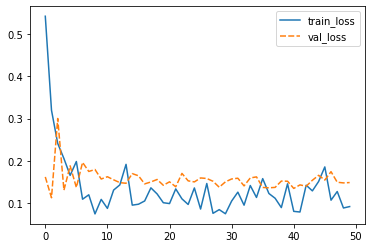

In [28]:
model_ft = models.resnet101(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft,train_losses,val_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=500)
dump_output(model_ft,train_losses[0:50],val_losses[0:50],'resnet101_lrscheduler_wholenetwork')

E8)Train lastlayer, LR scheduler, 100 epochs, resnet101
----------------------------------

Resnet101, train the last layer



In [8]:
model_conv = torchvision.models.resnet101(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_ft,train_losses,val_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=500)

NameError: name 'model_ft' is not defined

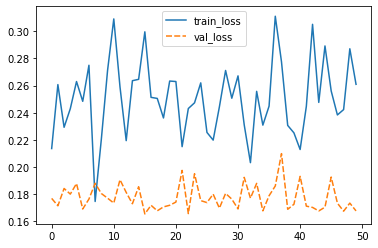

In [30]:
dump_output(model_ft,train_losses[0:50],val_losses[0:50],'resnet101_lrscheduler_lastlayer')

Epoch 0/499
----------
train Loss: 0.5699 Acc: 0.6926
train Rajat Best_Acc: 0.0000 Epoch_Acc: 0.6926
val Loss: 0.1458 Acc: 0.9673
val Rajat Best_Acc: 0.0000 Epoch_Acc: 0.9673

Epoch 1/499
----------
train Loss: 0.3013 Acc: 0.8525
train Rajat Best_Acc: 0.9673 Epoch_Acc: 0.8525
val Loss: 0.0995 Acc: 0.9739
val Rajat Best_Acc: 0.9673 Epoch_Acc: 0.9739

Epoch 2/499
----------
train Loss: 0.2139 Acc: 0.9098
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9098
val Loss: 0.0724 Acc: 0.9739
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9739

Epoch 3/499
----------
train Loss: 0.1426 Acc: 0.9303
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9303
val Loss: 0.0747 Acc: 0.9673
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9673

Epoch 4/499
----------
train Loss: 0.0988 Acc: 0.9631
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9631
val Loss: 0.1340 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 5/499
----------
train Loss: 0.1348 Acc: 0.9426
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9426
val Loss: 0.1073 Ac

val Loss: 0.0859 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 47/499
----------
train Loss: 0.1385 Acc: 0.9426
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9426
val Loss: 0.0848 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 48/499
----------
train Loss: 0.1716 Acc: 0.9344
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9344
val Loss: 0.0969 Acc: 0.9673
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9673

Epoch 49/499
----------
train Loss: 0.1609 Acc: 0.9303
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9303
val Loss: 0.0924 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 50/499
----------
train Loss: 0.1365 Acc: 0.9467
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9467
val Loss: 0.0895 Acc: 0.9673
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9673

Epoch 51/499
----------
train Loss: 0.0919 Acc: 0.9672
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9672
val Loss: 0.0941 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 52/499
----------
train Loss: 0.07

train Loss: 0.1452 Acc: 0.9549
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9549
val Loss: 0.0985 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 94/499
----------
train Loss: 0.1012 Acc: 0.9590
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9590
val Loss: 0.0919 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 95/499
----------
train Loss: 0.0916 Acc: 0.9590
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9590
val Loss: 0.1029 Acc: 0.9673
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9673

Epoch 96/499
----------
train Loss: 0.0859 Acc: 0.9672
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9672
val Loss: 0.0873 Acc: 0.9673
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9673

Epoch 97/499
----------
train Loss: 0.0462 Acc: 0.9918
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9918
val Loss: 0.0876 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 98/499
----------
train Loss: 0.0975 Acc: 0.9631
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9631
val Loss: 0.0886 Acc: 0.9608
val Raja

val Loss: 0.0922 Acc: 0.9673
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9673

Epoch 140/499
----------
train Loss: 0.1008 Acc: 0.9631
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9631
val Loss: 0.0926 Acc: 0.9673
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9673

Epoch 141/499
----------
train Loss: 0.1129 Acc: 0.9590
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9590
val Loss: 0.0906 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 142/499
----------
train Loss: 0.1443 Acc: 0.9385
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9385
val Loss: 0.0997 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 143/499
----------
train Loss: 0.1054 Acc: 0.9508
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9508
val Loss: 0.0906 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 144/499
----------
train Loss: 0.1350 Acc: 0.9590
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9590
val Loss: 0.0866 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 145/499
----------
train Loss

train Loss: 0.1258 Acc: 0.9590
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9590
val Loss: 0.0875 Acc: 0.9673
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9673

Epoch 187/499
----------
train Loss: 0.0885 Acc: 0.9549
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9549
val Loss: 0.0942 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 188/499
----------
train Loss: 0.1064 Acc: 0.9549
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9549
val Loss: 0.0992 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 189/499
----------
train Loss: 0.1034 Acc: 0.9672
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9672
val Loss: 0.0897 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 190/499
----------
train Loss: 0.0904 Acc: 0.9590
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9590
val Loss: 0.0882 Acc: 0.9673
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9673

Epoch 191/499
----------
train Loss: 0.0564 Acc: 0.9836
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9836
val Loss: 0.0924 Acc: 0.9673
val

val Loss: 0.0942 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 233/499
----------
train Loss: 0.0979 Acc: 0.9631
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9631
val Loss: 0.0911 Acc: 0.9673
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9673

Epoch 234/499
----------
train Loss: 0.0785 Acc: 0.9795
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9795
val Loss: 0.0832 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 235/499
----------
train Loss: 0.1168 Acc: 0.9549
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9549
val Loss: 0.0819 Acc: 0.9673
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9673

Epoch 236/499
----------
train Loss: 0.0832 Acc: 0.9631
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9631
val Loss: 0.0974 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 237/499
----------
train Loss: 0.1151 Acc: 0.9590
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9590
val Loss: 0.0890 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 238/499
----------
train Loss

train Loss: 0.1710 Acc: 0.9303
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9303
val Loss: 0.0876 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 280/499
----------
train Loss: 0.0934 Acc: 0.9590
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9590
val Loss: 0.0951 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 281/499
----------
train Loss: 0.0718 Acc: 0.9877
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9877
val Loss: 0.1072 Acc: 0.9673
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9673

Epoch 282/499
----------
train Loss: 0.0705 Acc: 0.9754
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9754
val Loss: 0.0905 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 283/499
----------
train Loss: 0.0745 Acc: 0.9713
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9713
val Loss: 0.0996 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 284/499
----------
train Loss: 0.0882 Acc: 0.9754
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9754
val Loss: 0.0877 Acc: 0.9608
val

val Loss: 0.1055 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 326/499
----------
train Loss: 0.1332 Acc: 0.9508
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9508
val Loss: 0.0899 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 327/499
----------
train Loss: 0.0822 Acc: 0.9795
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9795
val Loss: 0.0915 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 328/499
----------
train Loss: 0.0919 Acc: 0.9672
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9672
val Loss: 0.0915 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 329/499
----------
train Loss: 0.1033 Acc: 0.9713
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9713
val Loss: 0.0904 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 330/499
----------
train Loss: 0.1058 Acc: 0.9631
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9631
val Loss: 0.0918 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 331/499
----------
train Loss

train Loss: 0.1563 Acc: 0.9426
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9426
val Loss: 0.0955 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 373/499
----------
train Loss: 0.1031 Acc: 0.9590
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9590
val Loss: 0.0851 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 374/499
----------
train Loss: 0.0768 Acc: 0.9754
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9754
val Loss: 0.0925 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 375/499
----------
train Loss: 0.0975 Acc: 0.9672
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9672
val Loss: 0.0898 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 376/499
----------
train Loss: 0.1033 Acc: 0.9631
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9631
val Loss: 0.0989 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 377/499
----------
train Loss: 0.0537 Acc: 0.9836
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9836
val Loss: 0.0917 Acc: 0.9608
val

val Loss: 0.0904 Acc: 0.9673
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9673

Epoch 419/499
----------
train Loss: 0.1008 Acc: 0.9631
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9631
val Loss: 0.0981 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 420/499
----------
train Loss: 0.0733 Acc: 0.9754
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9754
val Loss: 0.1011 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 421/499
----------
train Loss: 0.1110 Acc: 0.9549
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9549
val Loss: 0.0947 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 422/499
----------
train Loss: 0.1000 Acc: 0.9590
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9590
val Loss: 0.0830 Acc: 0.9673
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9673

Epoch 423/499
----------
train Loss: 0.2062 Acc: 0.9221
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9221
val Loss: 0.0835 Acc: 0.9673
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9673

Epoch 424/499
----------
train Loss

train Loss: 0.1059 Acc: 0.9713
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9713
val Loss: 0.0853 Acc: 0.9673
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9673

Epoch 466/499
----------
train Loss: 0.1329 Acc: 0.9508
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9508
val Loss: 0.0928 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 467/499
----------
train Loss: 0.1143 Acc: 0.9631
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9631
val Loss: 0.0908 Acc: 0.9542
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9542

Epoch 468/499
----------
train Loss: 0.0843 Acc: 0.9713
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9713
val Loss: 0.1015 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 469/499
----------
train Loss: 0.1039 Acc: 0.9672
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9672
val Loss: 0.0917 Acc: 0.9608
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9608

Epoch 470/499
----------
train Loss: 0.1137 Acc: 0.9549
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9549
val Loss: 0.1037 Acc: 0.9608
val

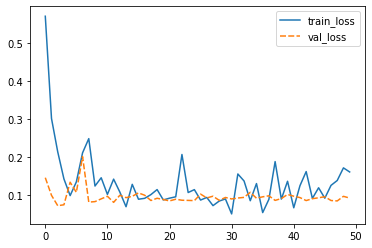

In [8]:
model_ft = models.resnet152(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft,train_losses,val_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=500)
dump_output(model_ft,train_losses[0:50],val_losses[0:50],'resnet152_lrscheduler_wholenetwork')

In [ ]:
model_conv = torchvision.models.resnet152(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_ft,train_losses,val_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=500)
dump_output(model_ft,train_losses[0:50],val_losses[0:50],'resnet152_lrscheduler_lastlayer')

Epoch 0/499
----------
train Loss: 0.2284 Acc: 0.9098
train Rajat Best_Acc: 0.0000 Epoch_Acc: 0.9098


/home/bashturtle/anaconda3/envs/gpuenv/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


val Loss: 0.1006 Acc: 0.9739
val Rajat Best_Acc: 0.0000 Epoch_Acc: 0.9739

Epoch 1/499
----------
train Loss: 0.1821 Acc: 0.9221
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9221
val Loss: 0.0993 Acc: 0.9739
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9739

Epoch 2/499
----------
train Loss: 0.1701 Acc: 0.9180
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9180
val Loss: 0.0956 Acc: 0.9673
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9673

Epoch 3/499
----------
train Loss: 0.1348 Acc: 0.9549
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9549
val Loss: 0.1074 Acc: 0.9673
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9673

Epoch 4/499
----------
train Loss: 0.1227 Acc: 0.9631
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9631
val Loss: 0.1008 Acc: 0.9739
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9739

Epoch 5/499
----------
train Loss: 0.1248 Acc: 0.9549
train Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9549
val Loss: 0.0947 Acc: 0.9739
val Rajat Best_Acc: 0.9739 Epoch_Acc: 0.9739

Epoch 6/499
----------
train Loss: 0.1893 Acc

train Loss: 0.1615 Acc: 0.9303
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9303
val Loss: 0.1077 Acc: 0.9739
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9739

Epoch 48/499
----------
train Loss: 0.1840 Acc: 0.9426
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9426
val Loss: 0.1066 Acc: 0.9673
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9673

Epoch 49/499
----------
train Loss: 0.1864 Acc: 0.9180
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9180
val Loss: 0.1068 Acc: 0.9608
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9608

Epoch 50/499
----------
train Loss: 0.2067 Acc: 0.9262
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9262
val Loss: 0.1245 Acc: 0.9608
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9608

Epoch 51/499
----------
train Loss: 0.1758 Acc: 0.9549
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9549
val Loss: 0.1079 Acc: 0.9608
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9608

Epoch 52/499
----------
train Loss: 0.1969 Acc: 0.9303
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9303
val Loss: 0.0945 Acc: 0.9739
val Raja

val Loss: 0.0944 Acc: 0.9673
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9673

Epoch 94/499
----------
train Loss: 0.2599 Acc: 0.8893
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.8893
val Loss: 0.1071 Acc: 0.9608
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9608

Epoch 95/499
----------
train Loss: 0.2220 Acc: 0.9139
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9139
val Loss: 0.1047 Acc: 0.9673
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9673

Epoch 96/499
----------
train Loss: 0.1802 Acc: 0.9344
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9344
val Loss: 0.0952 Acc: 0.9739
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9739

Epoch 97/499
----------
train Loss: 0.1566 Acc: 0.9385
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9385
val Loss: 0.0976 Acc: 0.9739
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9739

Epoch 98/499
----------
train Loss: 0.1959 Acc: 0.9221
train Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9221
val Loss: 0.1142 Acc: 0.9608
val Rajat Best_Acc: 0.9804 Epoch_Acc: 0.9608

Epoch 99/499
----------
train Loss: 0.21